In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# Replace this string with the actual folder path where train_curriculum.py lives
script_folder = "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents_uncertainty/scripts"

if script_folder not in sys.path:
    sys.path.append(script_folder)

from train_curriculum import main as run_training

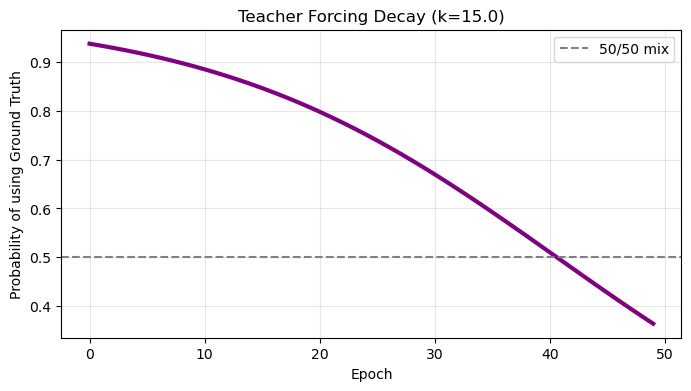

In [2]:
def plot_schedule(epochs=50, k_decay=15.0):
    x = np.arange(epochs)
    y = [float(k_decay) / (float(k_decay) + np.exp(e / float(k_decay))) for e in x]
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, linewidth=3, color='purple')
    plt.title(f"Teacher Forcing Decay (k={k_decay})")
    plt.xlabel("Epoch")
    plt.ylabel("Probability of using Ground Truth")
    plt.grid(True, alpha=0.3)
    plt.axhline(0.5, linestyle='--', color='gray', label="50/50 mix")
    plt.legend()
    plt.show()

# Visualize your settings before running
plot_schedule(epochs=50, k_decay=15.0)

In [3]:
import sys
import os

# Ensure current dir is in path
sys.path.append(os.getcwd())

# Import from the newly saved file
from train_curriculum import main as run_training

# Setup arguments
sys.argv = [
    "train_curriculum.py",
    "--data", "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents_uncertainty/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1771446846329.nc",
    "--out", "runs/curriculum_v2",
    "--horizon", "6",             
    "--k-decay", "15.0",          
    "--epochs", "500",
    "--batch-size", "8",
    "--regrid-h", "64",           # Added to match your snippet
    "--regrid-w", "64"            # Added to match your snippet
]

try:
    run_training()
except SystemExit:
    pass

Loading /home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents_uncertainty/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1771446846329.nc...
Computing Z-Score stats on training set...
Starting Curriculum Training (Horizon=6, Decay=15.0)


Ep 0 | TF=0.94:  16%|█▌        | 247/1535 [00:26<02:16,  9.47it/s, loss=0.247]


KeyboardInterrupt: 

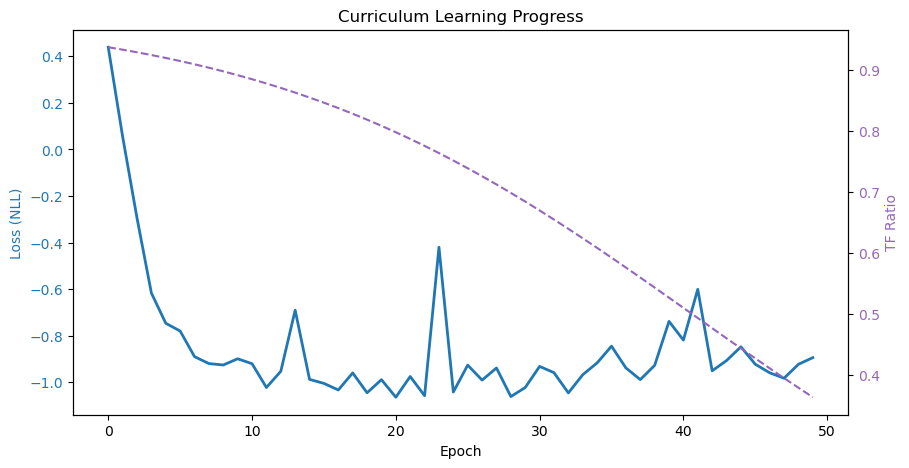

In [ ]:
import json
# Load the history file generated
log_path = "runs/curriculum_v1/history.json"

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        hist = json.load(f)
        
    epochs = [h['epoch'] for h in hist]
    loss = [h['loss'] for h in hist]
    tf = [h['tf_ratio'] for h in hist]

    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (NLL)', color='tab:blue')
    ax1.plot(epochs, loss, color='tab:blue', linewidth=2, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('TF Ratio', color='tab:purple') 
    ax2.plot(epochs, tf, color='tab:purple', linestyle='--', label='Teacher Forcing Ratio')
    ax2.tick_params(axis='y', labelcolor='tab:purple')

    plt.title("Curriculum Learning Progress")
    plt.show()
else:
    print("No history found. Did training finish?")

In [ ]:
# --- Helper Functions ---

def inverse_zscore(uv_tensor, stats):
    """
    Converts (2, H, W) normalized tensor back to physical units (m/s).
    """
    if isinstance(uv_tensor, torch.Tensor):
        uv = uv_tensor.cpu().numpy()
    else:
        uv = uv_tensor.copy()
        
    # uv[0] is U, uv[1] is V
    u_denorm = uv[0] * stats.u_std + stats.u_mean
    v_denorm = uv[1] * stats.v_std + stats.v_mean
    
    return np.stack([u_denorm, v_denorm], axis=0)

def predict_autoregressive(model, initial_input, steps=12, device='cuda'):
    """
    Performs recursive prediction: 
    Input(t-2, t-1, t) -> Pred(t+1)
    Input(t-1, t, t+1) -> Pred(t+2) ...
    """
    model.eval()
    # Ensure input is (1, seq_len, 2, H, W)
    current_seq = initial_input.clone().to(device)
    if current_seq.ndim == 4: 
        current_seq = current_seq.unsqueeze(0)
        
    predictions = []
    
    with torch.no_grad():
        for _ in range(steps):
            # Curriculum model returns (mean, logvar)
            mu, logvar = model(current_seq)
            
            # We use the MEAN (mu) for the next step's input
            pred_frame = mu  # (1, 2, H, W)
            predictions.append(pred_frame.cpu().numpy()[0])
            
            # Update sequence: Drop oldest frame (index 0), append new prediction
            # current_seq is (B, Seq, C, H, W) -> we slice dim 1
            current_seq = torch.cat([current_seq[:, 1:], pred_frame.unsqueeze(1)], dim=1)
            
    return np.array(predictions) # Shape: (steps, 2, H, W)

In [ ]:
import json
import torch
import numpy as np
from src.models.unet_convlstm_unc import UNetConvLSTMUncertainty

# --- 1. Load the Stats for Denormalization ---
# We need these to convert the model's output back to m/s
stats_path = "runs/curriculum_v2/stats.json"

if os.path.exists(stats_path):
    with open(stats_path, 'r') as f:
        stats_dict = json.load(f)
        
    # Reconstruct the ZScoreStats object
    class ZScoreStats:
        def __init__(self, u_mean, u_std, v_mean, v_std):
            self.u_mean = u_mean
            self.u_std = u_std
            self.v_mean = v_mean
            self.v_std = v_std
            
    stats = ZScoreStats(
        stats_dict['u_mean'], stats_dict['u_std'],
        stats_dict['v_mean'], stats_dict['v_std']
    )
    print("Stats loaded successfully.")
else:
    print(f"ERROR: Stats file not found at {stats_path}")

# --- 2. Load the Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the architecture (Must match what you used in training!)
model = UNetConvLSTMUncertainty(base_ch=32, lstm_ch=128).to(device)

# Load the weights
ckpt_path = "runs/curriculum_v1/last.pt"

if os.path.exists(ckpt_path):
    print(f"Loading weights from {ckpt_path}...")
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval() # Set to evaluation mode
    print("Model loaded and ready for inference.")
else:
    print(f"ERROR: Checkpoint not found at {ckpt_path}")

Stats loaded successfully.
Loading weights from runs/curriculum_v1/last.pt...
Model loaded and ready for inference.


/tmp/ipykernel_67922/2861396434.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset

# --- 1. Load the Data ---
# Use the same path and settings as your training
data_path = "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents/src/data/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1770985217793.nc"

print("Loading data for inference...")
# Note: We must use the same regrid settings as training (64x64)
uv, _, _, _ = load_cmems_uv(
    data_path, 
    u_var="utotal", 
    v_var="vtotal",
    regrid_hw=(64, 64), 
    depth_index=0
)

# --- 2. Normalize using the Saved Stats ---
# We must use the stats we loaded from the JSON file earlier
print("Applying Normalization...")
# Helper from your script
def apply_zscore(uv, stats):
    uv_n = uv.copy()
    uv_n[:,0] = (uv_n[:,0] - stats.u_mean) / stats.u_std
    uv_n[:,1] = (uv_n[:,1] - stats.v_mean) / stats.v_std
    return uv_n

# Apply stats (assumes 'stats' object exists from the previous cell)
uv_norm = apply_zscore(uv, stats)

# --- 3. Create Validation Dataset ---
# We need to split the data exactly as we did in training to look at the validation set
train_frac = 0.7
split_idx = int(len(uv_norm) * train_frac)
val_data = uv_norm[split_idx:]

# Define the Dataset Class locally if not imported
class SequenceUVDataset(SlidingWindowUVDataset):
    def __init__(self, data, seq_len=12, horizon=6):
        self.data = data
        self.seq_len = seq_len
        self.horizon = horizon

    def __getitem__(self, i):
        start_x = i
        end_x = i + self.seq_len
        end_y = end_x + self.horizon
        X = self.data[start_x : end_x]       
        Y_seq = self.data[end_x : end_y]     
        return torch.from_numpy(X).float(), torch.from_numpy(Y_seq).float()

    def __len__(self):
        return len(self.data) - self.seq_len - self.horizon + 1

# Instantiate ds_val
ds_val = SequenceUVDataset(val_data, seq_len=12, horizon=6)
print(f"Validation Dataset Created. Size: {len(ds_val)}")

Loading data for inference...
Applying Normalization...
Validation Dataset Created. Size: 297


Generating autoregressive rollout for 12 steps...
Global Speed Range: 0.00 - 0.74 m/s
Global Error Max: 0.59 m/s


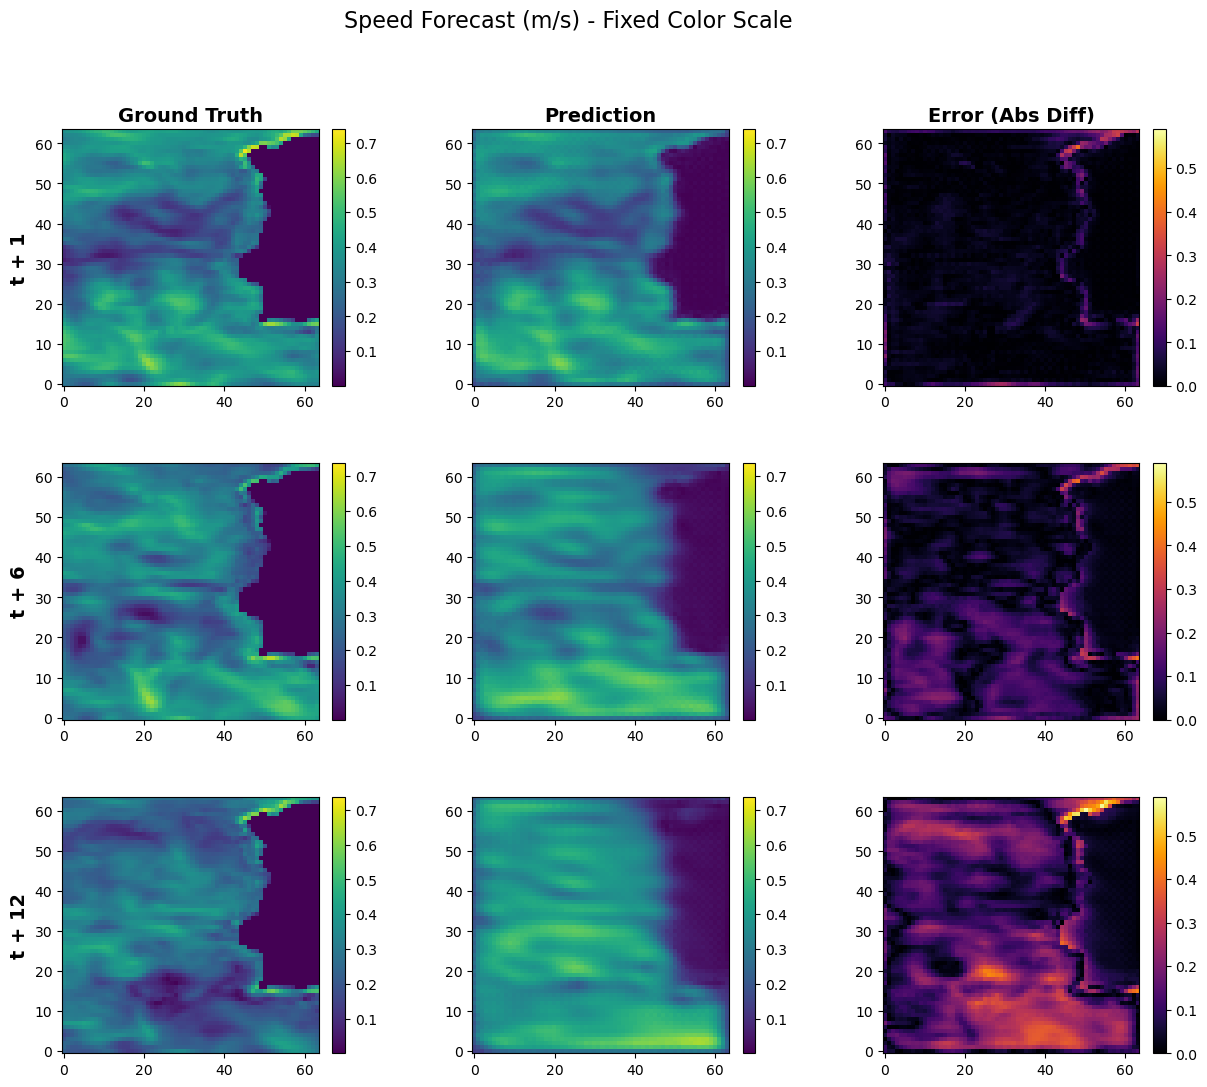

In [ ]:
# --- Configuration ---
sample_idx = 50            
steps_to_plot = [1, 6, 12] 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 1. Get Initial Input
input_tensor, _ = ds_val[sample_idx] 
input_seq = input_tensor.unsqueeze(0).to(device)

# 2. Generate 12 steps of predictions recursively
print(f"Generating autoregressive rollout for 12 steps...")
preds_norm = predict_autoregressive(model, input_seq, steps=12, device=device)

# --- PRE-CALCULATE GLOBAL RANGES ---
# We need to collect all frames to find the true Min/Max across the whole sequence
all_preds = []
all_gts   = []
all_errs  = []

for t in range(1, 13): # Loop through all 12 steps
    # Prediction
    pred_uv = inverse_zscore(preds_norm[t-1], stats)
    speed_pred = np.sqrt(pred_uv[0]**2 + pred_uv[1]**2)
    all_preds.append(speed_pred)
    
    # Ground Truth
    gt_idx = sample_idx + ds_val.seq_len + (t - 1)
    gt_uv_norm = ds_val.data[gt_idx]
    gt_uv = inverse_zscore(gt_uv_norm, stats)
    speed_gt = np.sqrt(gt_uv[0]**2 + gt_uv[1]**2)
    all_gts.append(speed_gt)
    
    # Error
    all_errs.append(np.abs(speed_pred - speed_gt))

# Find Global Min/Max for Speed (GT and Pred)
# We calculate this across ALL time steps so the colorbar is fixed for the whole plot
global_vmin = min(np.min(all_preds), np.min(all_gts))
global_vmax = max(np.max(all_preds), np.max(all_gts))

# Find Global Max for Error (keeps error heatmaps comparable)
global_err_max = np.max(all_errs)

print(f"Global Speed Range: {global_vmin:.2f} - {global_vmax:.2f} m/s")
print(f"Global Error Max: {global_err_max:.2f} m/s")

# 3. Setup Plot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)
cols = ['Ground Truth', 'Prediction', 'Error (Abs Diff)']

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

# 4. Plotting Loop
for i, t_step in enumerate(steps_to_plot):
    # Retrieve pre-calculated arrays (index is t_step - 1)
    speed_gt   = all_gts[t_step - 1]
    speed_pred = all_preds[t_step - 1]
    speed_err  = all_errs[t_step - 1]
    
    # --- Plotting with GLOBAL ranges ---
    
    # Ground Truth
    im1 = axes[i, 0].imshow(speed_gt, cmap='viridis', origin='lower', 
                            vmin=global_vmin, vmax=global_vmax)
    axes[i, 0].set_ylabel(f"t + {t_step}", fontsize=14, fontweight='bold')
    # Only add colorbar to the last row to save space (optional, or keep on all)
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)
    
    # Prediction
    im2 = axes[i, 1].imshow(speed_pred, cmap='viridis', origin='lower', 
                            vmin=global_vmin, vmax=global_vmax)
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)
    
    # Error (Use independent error scale, or fixed global error scale)
    im3 = axes[i, 2].imshow(speed_err, cmap='inferno', origin='lower',
                            vmin=0, vmax=global_err_max)
    plt.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.suptitle(f"Speed Forecast (m/s) - Fixed Color Scale", fontsize=16)
plt.show()